In [2]:
import os
import numpy as np
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import pandas as pd

In [19]:
x = np.load('pose_landmarks_dataset.npy')
y = np.load('pose_landmarks_labels.npy')

In [29]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [30]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, TimeDistributed
from keras.optimizers import Adam

num_classes = len(np.unique(y_train_encoded))

In [35]:
from tensorflow.keras.layers import GRU

model_gru = Sequential()
model_gru.add(GRU(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model_gru.add(Dropout(0.4))
model_gru.add(GRU(128, return_sequences=True))
model_gru.add(Dropout(0.4))
model_gru.add(GRU(64, return_sequences=True))
model_gru.add(Dropout(0.4))
model_gru.add(TimeDistributed(Dense(64, activation='relu')))
model_gru.add(Dropout(0.4))
model_gru.add(GRU(32))
model_gru.add(Dropout(0.4))
model_gru.add(Dense(num_classes, activation='softmax'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [42]:
optimizer_gru = Adam(learning_rate=0.001)

model_gru.compile(optimizer=optimizer_gru, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [44]:
# Train the GRU model
history_gru = model_gru.fit(x_train, y_train_encoded, 
                            validation_data=(x_val, y_val_encoded), 
                            epochs=600, batch_size=32)

loss_gru, gru_val_accuracy = model_gru.evaluate(x_val, y_val_encoded, verbose=0)
print(f'GRU Model Validation Accuracy: {gru_val_accuracy:.4f}')

Epoch 1/600
150/150 ━━━━━━━━━━━━━━━━━━━━ 16s 108ms/step - accuracy: 0.3005 - loss: 1.7514 - val_accuracy: 0.3144 - val_loss: 1.6862
Epoch 2/600
150/150 ━━━━━━━━━━━━━━━━━━━━ 16s 104ms/step - accuracy: 0.3077 - loss: 1.7308 - val_accuracy: 0.3228 - val_loss: 1.6661
Epoch 3/600
150/150 ━━━━━━━━━━━━━━━━━━━━ 16s 108ms/step - accuracy: 0.3281 - loss: 1.6786 - val_accuracy: 0.3428 - val_loss: 1.6266
Epoch 4/600
150/150 ━━━━━━━━━━━━━━━━━━━━ 15s 102ms/step - accuracy: 0.3278 - loss: 1.6817 - val_accuracy: 0.3586 - val_loss: 1.6058
Epoch 5/600
150/150 ━━━━━━━━━━━━━━━━━━━━ 16s 106ms/step - accuracy: 0.3370 - loss: 1.6249 - val_accuracy: 0.3511 - val_loss: 1.5639
Epoch 6/600
150/150 ━━━━━━━━━━━━━━━━━━━━ 15s 103ms/step - accuracy: 0.3410 - loss: 1.6236 - val_accuracy: 0.3620 - val_loss: 1.5261
Epoch 7/600
150/150 ━━━━━━━━━━━━━━━━━━━━ 16s 105ms/step - accuracy: 0.3431 - loss: 1.5828 - val_accuracy: 0.3636 - val_loss: 1.4686
Epoch 8/600
150/150 ━━━━━━━━━━━━━━━━━━━━ 16s 104ms/step - accuracy: 0.3731 -

In [45]:
model_gru.save("/kaggle/working/gru_trained.h5")
loss, tf_keras_val_accuracy = model_gru.evaluate(x_val, y_val_encoded, verbose=0)
print(f'TensorFlow/Keras Model Validation Accuracy: {tf_keras_val_accuracy:.4f}')

y_pred = model_gru.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_val_encoded, y_pred_classes, target_names=label_encoder.classes_))

TensorFlow/Keras Model Validation Accuracy: 0.9166
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step
              precision    recall  f1-score   support

     1. loud       0.94      0.91      0.93       253
    2. quiet       0.97      0.97      0.97       236
    3. happy       0.90      0.95      0.93       229
      4. sad       0.94      0.94      0.94        95
5. Beautiful       0.77      0.93      0.84        99
     6. Ugly       0.88      0.79      0.83       119
     7. Deaf       0.95      0.84      0.89        87
    8. Blind       0.91      0.93      0.92        81

    accuracy                           0.92      1199
   macro avg       0.91      0.91      0.91      1199
weighted avg       0.92      0.92      0.92      1199



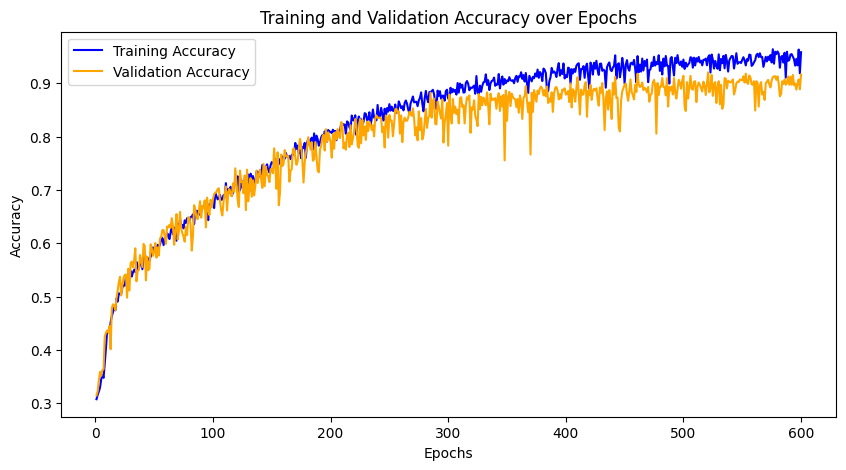

In [47]:
train_accuracy = history_gru.history['accuracy']
val_accuracy = history_gru.history['val_accuracy']
epochs = range(1, len(train_accuracy) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, label='Training Accuracy', color='blue')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='orange')

plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()